<a href="https://colab.research.google.com/github/figaone/ASSIGNMENT1ME592/blob/main/ASSIGNMENT1ME592.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
from datetime import datetime, timedelta, time

# 2 Simple Programing & Exploratory Analytics

(423, 419)


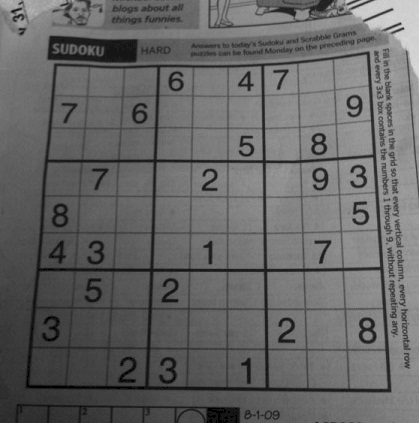

[[168 164 170 ... 206 206 206]
 [168 164 170 ... 205 205 205]
 [165 163 164 ... 206 206 206]
 ...
 [ 43  43  43 ... 130 133 136]
 [ 46  45  43 ... 132 134 134]
 [ 48  47  43 ... 132 132 131]]


In [4]:
# Load sudoku-original.png image in grayscale mode
img = cv2.imread('sudoku-original.png',0)
print(img.shape)
cv2_imshow(img)
print(img)

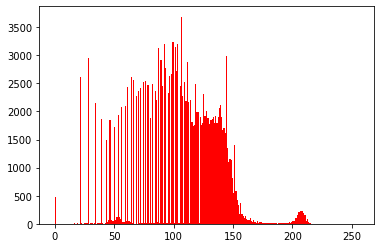

In [6]:
# Plot the histogram of Intensities
_= plt.hist(img.flatten(),256,[0,256],color = 'r')

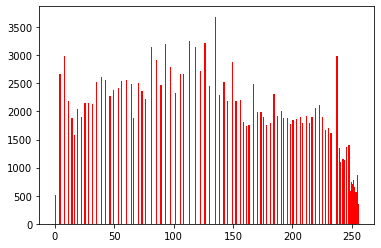

In [7]:
# Histogram equalization to improve contrast of image
equ = cv2.equalizeHist(img)
_= plt.hist(equ.flatten(),256,[0,256],color = 'r')

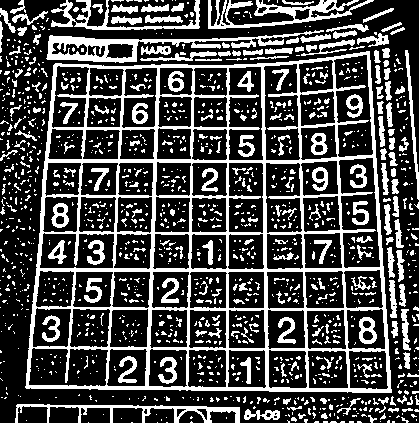

[[[ 55.  63.]]

 [[369.  51.]]

 [[ 25. 387.]]

 [[391. 392.]]]
(423, 419)


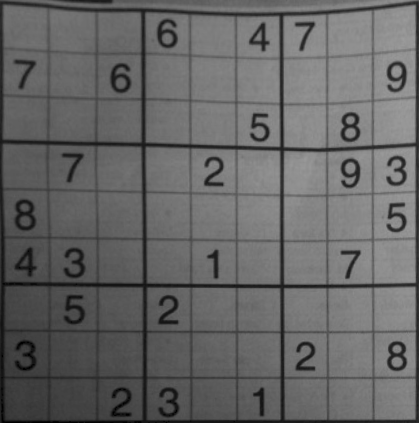

In [8]:
# Choose for appropriate points and perform a perspective transformation to obtain sodoku as a perfect square

#perform gaussian blur to remove noise from image and adaptive threshold to help detect contours
result = cv2.GaussianBlur(equ, (9, 9), 1)
result = cv2.adaptiveThreshold(result, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 1, 11, 2)
cv2_imshow(result)

contours, _ = cv2.findContours(result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# get the largest contours to be used to extract four corners
def extract_largest_contour(contours: list, min_contour_area: int = 20000) -> np.ndarray:
    for c in sorted(contours, key = cv2.contourArea, reverse = True)[:10]:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        if len(approx) == 4 and cv2.contourArea(c) >= min_contour_area:
            return approx
    
    return None
extract_largest_contour(contours=contours)

# get the four appropriate coners of the image using the
def extract_corners(pts: np.ndarray) -> np.ndarray:
    pts = pts.reshape((4, 2))
    rect = np.zeros((4, 1, 2), dtype = np.int32)

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[3] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[2] = pts[np.argmax(diff)]
    return np.float32(rect)

print(extract_corners(extract_largest_contour(contours=contours)))

# perform a perspective transformation
def warp(image: np.ndarray, src: np.ndarray, dst: np.ndarray, dsize: tuple) -> np.ndarray:
    matrix = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, matrix, dsize)

(height, width) = img.shape
print(img.shape)
dimensions = np.float32([[0, 0],[width, 0], [0, height],[width, height]])
board = warp(img.copy(), extract_corners(extract_largest_contour(contours=contours)), dimensions, (width, height))

cv2_imshow(board)

# Time Series

In [9]:
df = pd.read_csv('energydata_complete.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Energy Consumption
0,1/11/2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433
1,1/11/2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195
2,1/11/2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668
3,1/11/2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390
4,1/11/2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097


In [10]:
df.dtypes

date                   object
Appliances              int64
lights                  int64
T1                    float64
RH_1                  float64
T2                    float64
RH_2                  float64
T3                    float64
RH_3                  float64
T4                    float64
RH_4                  float64
T5                    float64
RH_5                  float64
T6                    float64
RH_6                  float64
T7                    float64
RH_7                  float64
T8                    float64
RH_8                  float64
T9                    float64
RH_9                  float64
T_out                 float64
Press_mm_hg           float64
RH_out                float64
Windspeed             float64
Visibility            float64
Tdewpoint             float64
Energy Consumption    float64
dtype: object

In [11]:
# convert Date feature data type to date time
df['date'] = pd.to_datetime(df['date'])

In [12]:
# extract the day of the week from the Date feature and add it under a new feature name 'weekday
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['weekday'] = df.date.dt.day_of_week.map(dayOfWeek)
df.head(10)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Energy Consumption,weekday
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.20,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.500000,92.000000,7.000000,63.000000,5.30,13.275433,Monday
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.20,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.600000,92.000000,6.666667,59.166667,5.20,18.606195,Monday
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.20,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.090000,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.700000,92.000000,6.333333,55.333333,5.10,28.642668,Monday
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.20,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.800000,92.000000,6.000000,51.500000,5.00,45.410390,Monday
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.20,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.900000,92.000000,5.666667,47.666667,4.90,10.084097,Monday
5,2016-01-11 17:50:00,50,40,19.890000,46.026667,19.20,44.500000,19.79,44.933333,18.890000,45.730000,17.133333,55.030000,6.300000,85.766667,17.133333,41.260000,18.1,48.590000,17.000000,45.29,6.02,734.000000,92.000000,5.333333,43.833333,4.80,44.919484,Monday
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.20,44.500000,19.79,44.900000,18.890000,45.790000,17.100000,54.966667,6.263333,86.090000,17.133333,41.200000,18.1,48.590000,17.000000,45.29,5.90,734.100000,92.000000,5.000000,40.000000,4.70,47.233763,Monday
7,2016-01-11 18:10:00,60,50,19.856667,45.560000,19.20,44.500000,19.73,44.900000,18.890000,45.863333,17.100000,54.900000,6.190000,86.423333,17.100000,41.200000,18.1,48.590000,17.000000,45.29,5.92,734.166667,91.833333,5.166667,40.000000,4.68,33.039890,Monday
8,2016-01-11 18:20:00,60,40,19.790000,45.597500,19.20,44.433333,19.73,44.790000,18.890000,45.790000,17.166667,55.000000,6.123333,87.226667,17.166667,41.400000,18.1,48.590000,17.000000,45.29,5.93,734.233333,91.666667,5.333333,40.000000,4.67,31.455702,Monday
9,2016-01-11 18:30:00,70,40,19.856667,46.090000,19.23,44.400000,19.79,44.863333,18.890000,46.096667,17.100000,55.000000,6.190000,87.626667,17.200000,41.500000,18.1,48.590000,17.000000,45.29,5.95,734.300000,91.500000,5.500000,40.000000,4.65,3.089314,Monday


In [14]:
# create a new feature for the hour of day
df['hourofday'] = df.date.dt.hour
df.head(10)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Energy Consumption,weekday,hourofday
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.20,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.500000,92.000000,7.000000,63.000000,5.30,13.275433,Monday,17
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.20,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.600000,92.000000,6.666667,59.166667,5.20,18.606195,Monday,17
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.20,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.090000,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.700000,92.000000,6.333333,55.333333,5.10,28.642668,Monday,17
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.20,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.800000,92.000000,6.000000,51.500000,5.00,45.410390,Monday,17
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.20,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.900000,92.000000,5.666667,47.666667,4.90,10.084097,Monday,17
5,2016-01-11 17:50:00,50,40,19.890000,46.026667,19.20,44.500000,19.79,44.933333,18.890000,45.730000,17.133333,55.030000,6.300000,85.766667,17.133333,41.260000,18.1,48.590000,17.000000,45.29,6.02,734.000000,92.000000,5.333333,43.833333,4.80,44.919484,Monday,17
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.20,44.500000,19.79,44.900000,18.890000,45.790000,17.100000,54.966667,6.263333,86.090000,17.133333,41.200000,18.1,48.590000,17.000000,45.29,5.90,734.100000,92.000000,5.000000,40.000000,4.70,47.233763,Monday,18
7,2016-01-11 18:10:00,60,50,19.856667,45.560000,19.20,44.500000,19.73,44.900000,18.890000,45.863333,17.100000,54.900000,6.190000,86.423333,17.100000,41.200000,18.1,48.590000,17.000000,45.29,5.92,734.166667,91.833333,5.166667,40.000000,4.68,33.039890,Monday,18
8,2016-01-11 18:20:00,60,40,19.790000,45.597500,19.20,44.433333,19.73,44.790000,18.890000,45.790000,17.166667,55.000000,6.123333,87.226667,17.166667,41.400000,18.1,48.590000,17.000000,45.29,5.93,734.233333,91.666667,5.333333,40.000000,4.67,31.455702,Monday,18
9,2016-01-11 18:30:00,70,40,19.856667,46.090000,19.23,44.400000,19.79,44.863333,18.890000,46.096667,17.100000,55.000000,6.190000,87.626667,17.200000,41.500000,18.1,48.590000,17.000000,45.29,5.95,734.300000,91.500000,5.500000,40.000000,4.65,3.089314,Monday,18


In [17]:
import datetime
# seven days after first day
ts = df['date'][0] + datetime.timedelta(days=7)
# consumption for one week from the data frame
one_week_cons = df.loc[df.date <= ts, :]
type(one_week_cons)

pandas.core.frame.DataFrame

In [18]:
one_week_cons.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Energy Consumption,weekday,hourofday
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,Monday,17
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,Monday,17
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,Monday,17
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,Monday,17
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,Monday,17


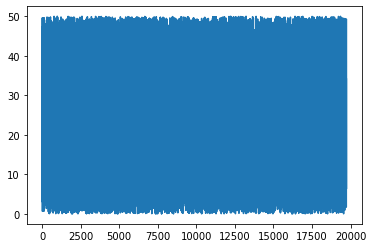

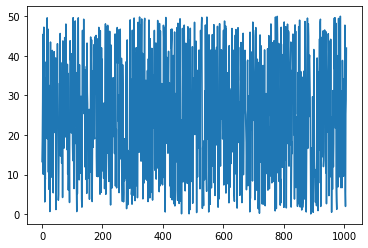

In [25]:
df_np = one_week_cons.to_numpy()

# plot for consumptiion for whole period
plt.figure
plt.plot(df['Energy Consumption'])
plt.show()

# plot for consumption in one week
plt.figure
plt.plot(one_week_cons['Energy Consumption'])
plt.show()

<bound method Artist.set of <matplotlib.axes._subplots.AxesSubplot object at 0x7f394d016150>>

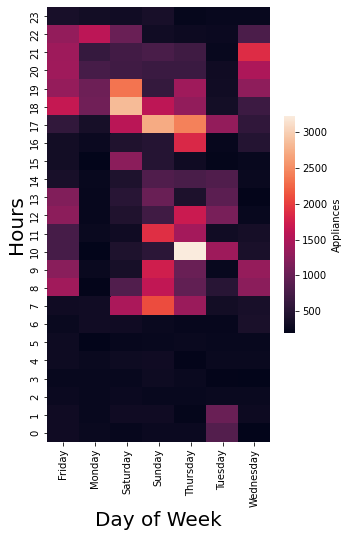

In [27]:
heatmap1_data = pd.pivot_table(one_week_cons, values='Appliances', 
                     index=['hourofday'], 
                     columns='weekday',aggfunc='sum')
heatmap1_data.sort_index(level=0, ascending=False, inplace=True)
plt.figure(figsize=(5,8))
ax = sns.heatmap(heatmap1_data, cbar_kws={'label': 'Appliances',"shrink": 0.5})
ax.set_xlabel('Day of Week').set_size(20)
ax.set_ylabel('Hours').set_size(20)
ax.set

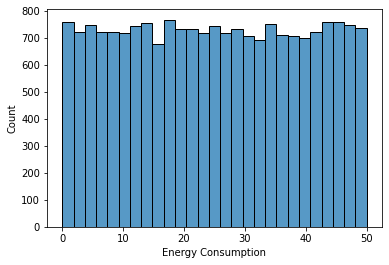

In [26]:
# histogram of energy consumption of appliances.
sns.histplot(data=df, x="Energy Consumption")

In [28]:
# function to calculate of seconds from midnight
def time_until_end_of_day(dt=None):
    """
    Get timedelta until end of day on the datetime passed, or current time.
    """
    if dt is None:
      print('no date')
      dt = df.date[0]
    tomorrow = dt + datetime.timedelta(days=1)
    return (datetime.datetime.combine(tomorrow, datetime.time.min) - dt).seconds

In [30]:
# Construct a feature variable NSM
df['NSM'] = df.date.apply(time_until_end_of_day)
df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Energy Consumption,weekday,hourofday,NSM
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.2000,48.900000,17.033333,45.5300,6.60,733.5,92.000000,7.000000,63.000000,5.3,13.275433,Monday,17,25200
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,41.560000,18.2000,48.863333,17.066667,45.5600,6.48,733.6,92.000000,6.666667,59.166667,5.2,18.606195,Monday,17,24600
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.090000,6.560000,83.156667,17.200000,41.433333,18.2000,48.730000,17.000000,45.5000,6.37,733.7,92.000000,6.333333,55.333333,5.1,28.642668,Monday,17,24000
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.1000,48.590000,17.000000,45.4000,6.25,733.8,92.000000,6.000000,51.500000,5.0,45.410390,Monday,17,23400
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.1000,48.590000,17.000000,45.4000,6.13,733.9,92.000000,5.666667,47.666667,4.9,10.084097,Monday,17,22800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,52.400000,24.796667,1.000000,24.500000,44.500000,24.7000,50.074000,23.200000,46.7900,22.70,755.2,55.666667,3.333333,23.666667,13.3,43.096812,Friday,17,24000
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,23.230000,52.326667,24.196667,1.000000,24.557143,44.414286,24.7000,49.790000,23.200000,46.7900,22.60,755.2,56.000000,3.500000,24.500000,13.3,49.282940,Friday,17,23400
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,23.230000,52.266667,23.626667,1.000000,24.540000,44.400000,24.7000,49.660000,23.200000,46.7900,22.50,755.2,56.333333,3.666667,25.333333,13.3,29.199117,Friday,17,22800
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,23.200000,52.200000,22.433333,1.000000,24.500000,44.295714,24.6625,49.518750,23.200000,46.8175,22.30,755.2,56.666667,3.833333,26.166667,13.2,6.322784,Friday,17,22200


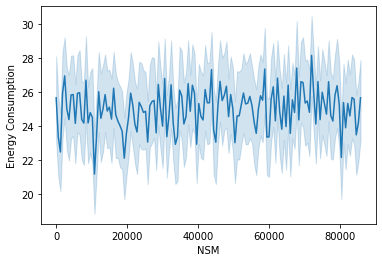

In [31]:
# Plot Energy consumption vs NSM
sns.lineplot(x="NSM", y="Energy Consumption", data=df)

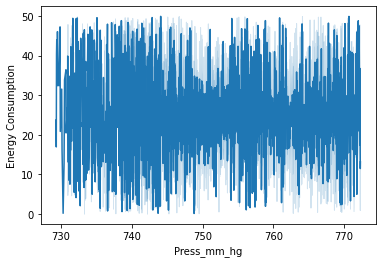

In [32]:
# Plot appliances energy consumption vs Press_mm_Hg
sns.lineplot(x="Press_mm_hg", y="Energy Consumption", data=df)

# 2.3 Multi-Variate

In [35]:
nasa_df = pd.read_table('airfoil_self_noise.dat',header = None)
nasa_df.columns = ['Frequency','Angle of attack','Chord length','Free-stream velocity','Suction side displacement thickness','Scaled Sound Pressure Level']

In [36]:
nasa_df

,Frequency,Angle of attack,Chord length,Free-stream velocity,Suction side displacement thickness,Scaled Sound Pressure Level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [37]:
# A function to calculate range
def Range(x):
  return x.max() - x.min()

In [38]:
# Find the descriptive statistics of the data
nasa_df.agg(["mean", "var", "median", "kurtosis","skew",Range])

,Frequency,Angle of attack,Chord length,Free-stream velocity,Suction side displacement thickness,Scaled Sound Pressure Level
mean,2.886381e+03,6.782302,0.136548,50.860745,0.011140,124.835943
var,9.938717e+06,35.024241,0.008750,242.511614,0.000173,47.591463
median,1.600000e+03,5.400000,0.101600,39.600000,0.004957,125.721000
kurtosis,5.708685e+00,-0.412951,-1.037964,-1.563951,2.218903,-0.314187
skew,2.137084e+00,0.689164,0.457457,0.235852,1.702165,-0.418952
Range,1.980000e+04,22.200000,0.279400,39.600000,0.058011,37.607000
